## Import Libraries and Data

In [21]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.feature_selection import f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.graphics.gofplots import qqplot
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import joblib
color_pal = sns.color_palette()

# Read the CSV file into Pandas DataFrame
data = pd.read_csv("Weather_data_2023_2024.csv", parse_dates=True, index_col="datetime")

## Data Exploration

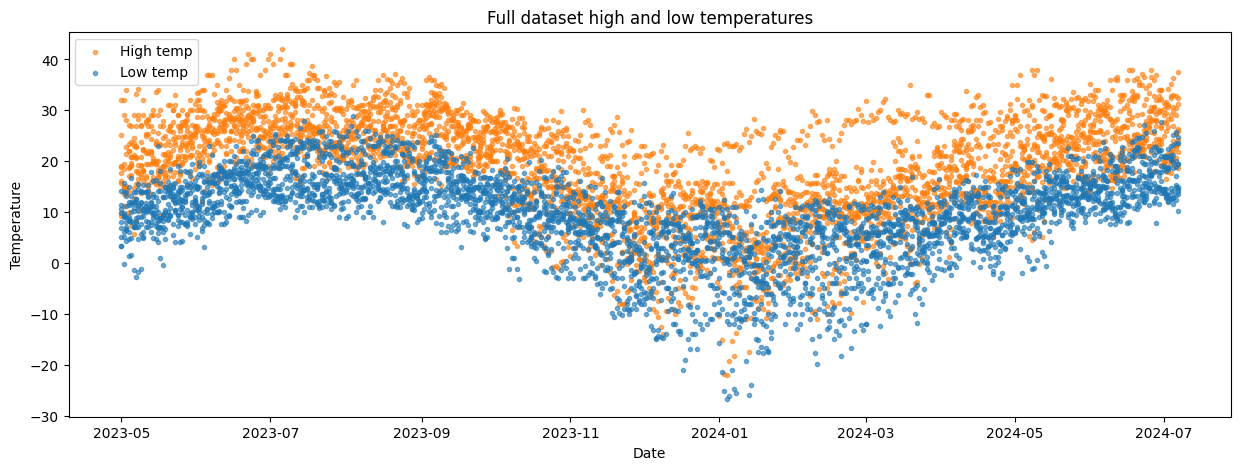

In [22]:
# Plot the tempmax and tempmin columns
fig, ax = plt.subplots(figsize=(15, 5))
plt.scatter(data.index, data['tempmax'], color=color_pal[1], label='High temp', alpha=0.6, marker='.')
plt.scatter(data.index, data['tempmin'], color=color_pal[0], label='Low temp', alpha=0.6, marker='.')

# Add titles and labels
plt.title('Full dataset high and low temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [23]:
print(data.shape)
data.isnull().sum()

(3906, 27)


location             0
tempmax              0
tempmin              0
temp                 0
feelslikemax         0
feelslikemin         0
feelslike            0
dew                  0
humidity             0
precip               0
precipprob           0
precipcover          0
snow                 0
snowdepth            0
windgust             0
windspeed            0
winddir              0
sealevelpressure     0
cloudcover           0
visibility           0
sunrise              0
sunset               0
moonphase            0
conditions           0
description          0
icon                 0
stations            53
dtype: int64

In [24]:
data.duplicated().sum()

0

In [25]:
# Drop Columns of No Interest
df = data.drop(columns=['stations', 'icon', 'description', 'conditions', 'sunset', 'sunrise'])

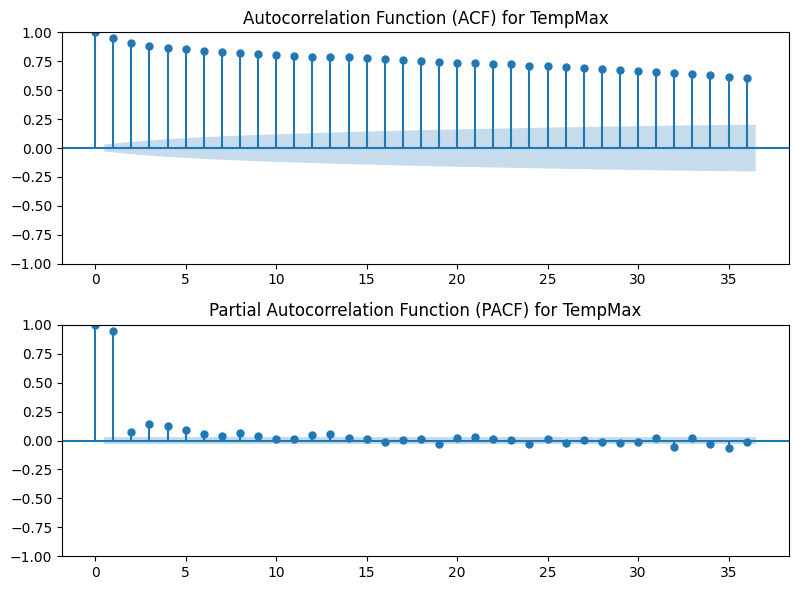

In [26]:
# Create a figure and subplots for ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

# Plot ACF
plot_acf(df['tempmax'], ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF) for TempMax')

# Plot PACF
plot_pacf(df['tempmax'], ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF) for TempMax')

# Adjust layout
plt.tight_layout()
plt.show()

## Identify Key Factors/Feature Selection

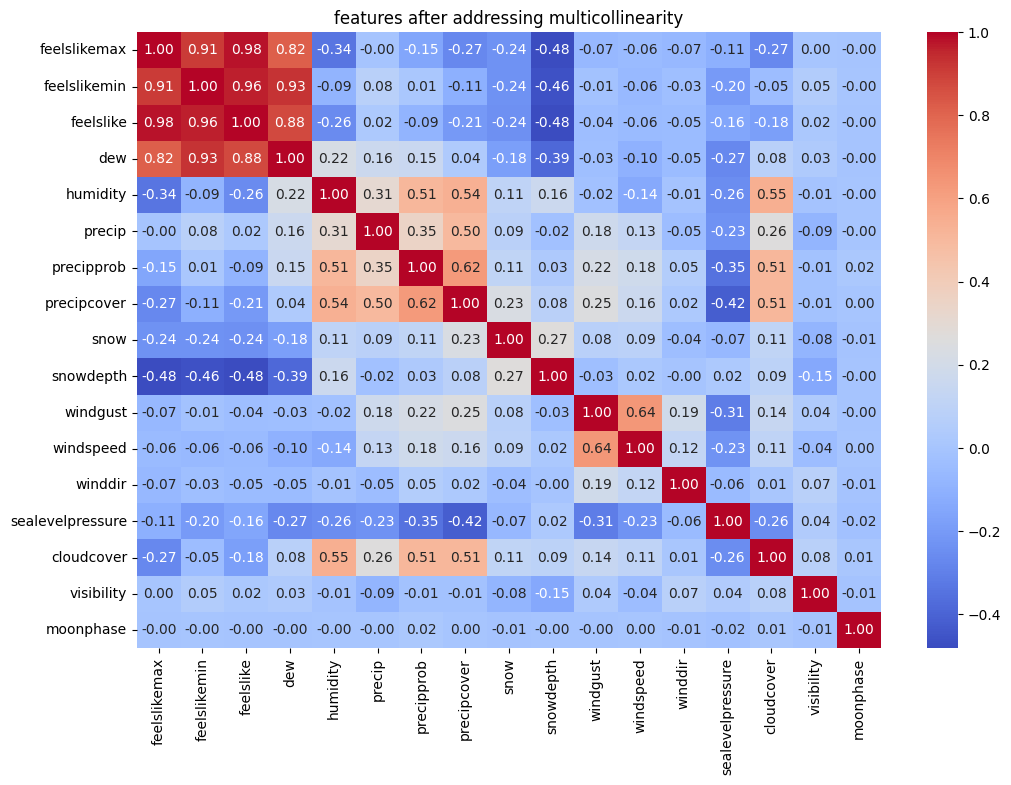

In [27]:
features = df[['feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'moonphase']]

y_max = df['tempmax']
y_min = df['tempmin']

df = df.select_dtypes(include=['number'])
correlation_matrix = features.corr()
plt.figure(figsize=(12, 8))
plt.title("features after addressing multicollinearity")
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [28]:
# Define the DataFrame with combined highly correlated features
df['feelslike_combined'] = df[['feelslikemin', 'feelslikemax', 'feelslike']].mean(axis=1)
df['dew_humidity'] = df[['dew', 'humidity']].mean(axis=1)

# Recalculate the features DataFrame without the original features
features_combined = df[['feelslike_combined', 'dew_humidity', 'precip', 'snow', 'snowdepth', 'winddir',
                        'visibility', 'moonphase']]

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = features_combined.columns
vif_data["VIF"] = [variance_inflation_factor(features_combined.values, i) for i in range(features_combined.shape[1])]

# Display features with high VIF
print( vif_data.sort_values(by="VIF", ascending=False))

              feature       VIF
1        dew_humidity  9.966406
6          visibility  4.224376
5             winddir  4.095284
0  feelslike_combined  3.666799
7           moonphase  3.447316
4           snowdepth  1.398886
2              precip  1.250394
3                snow  1.120895


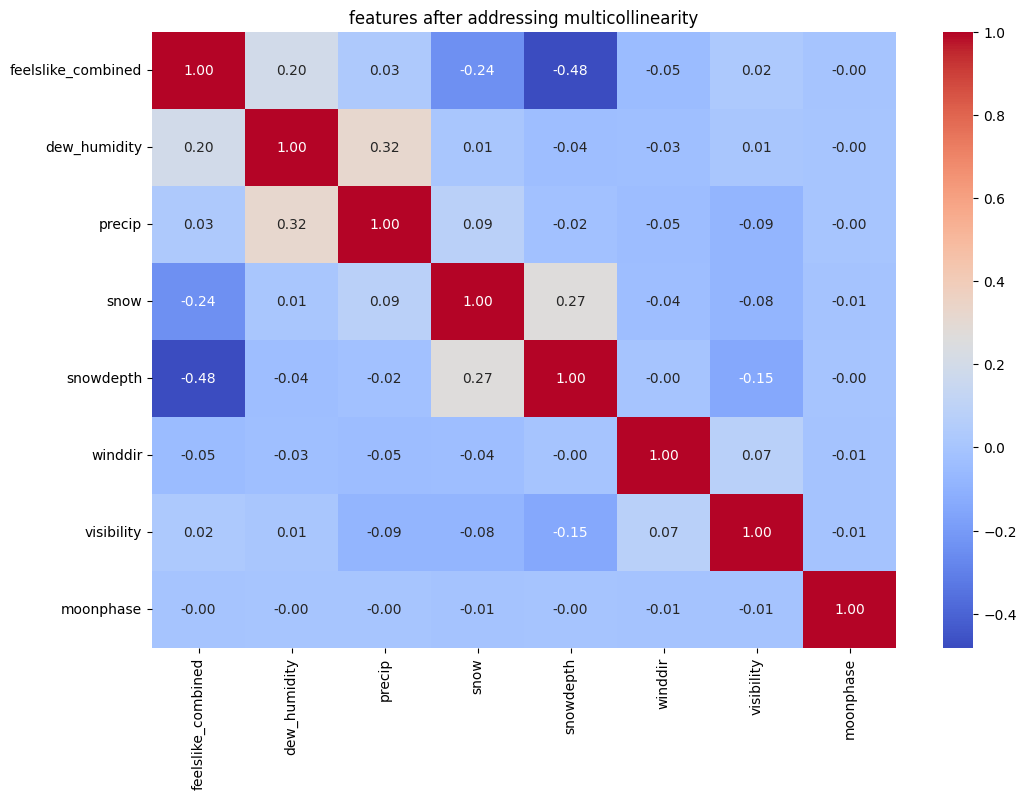

In [29]:
correlation_matrix = features_combined.corr()
plt.figure(figsize=(12, 8))
plt.title("features after addressing multicollinearity")
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

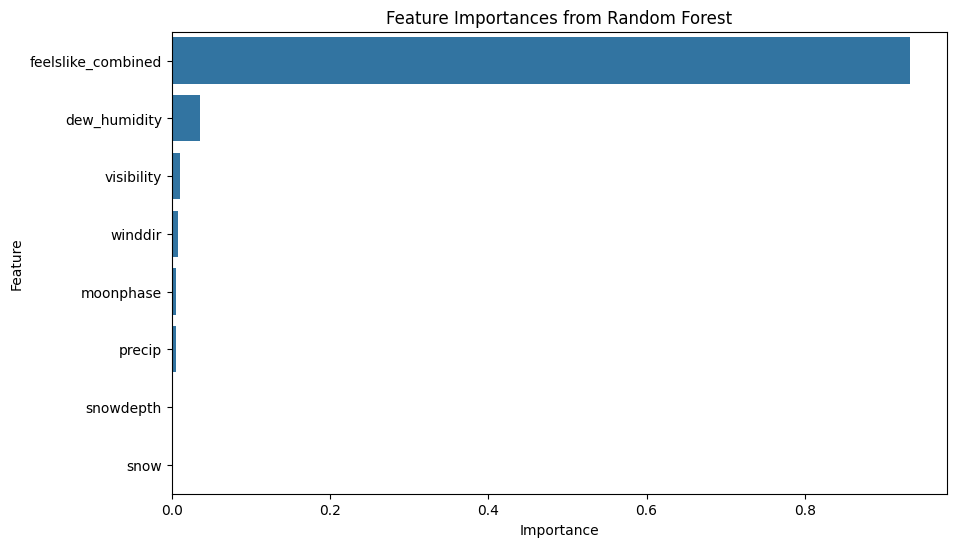

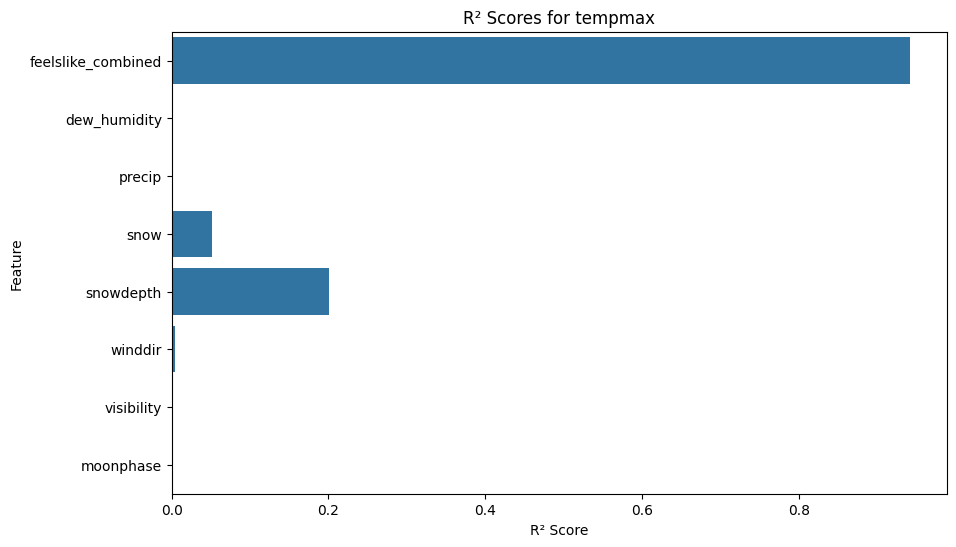

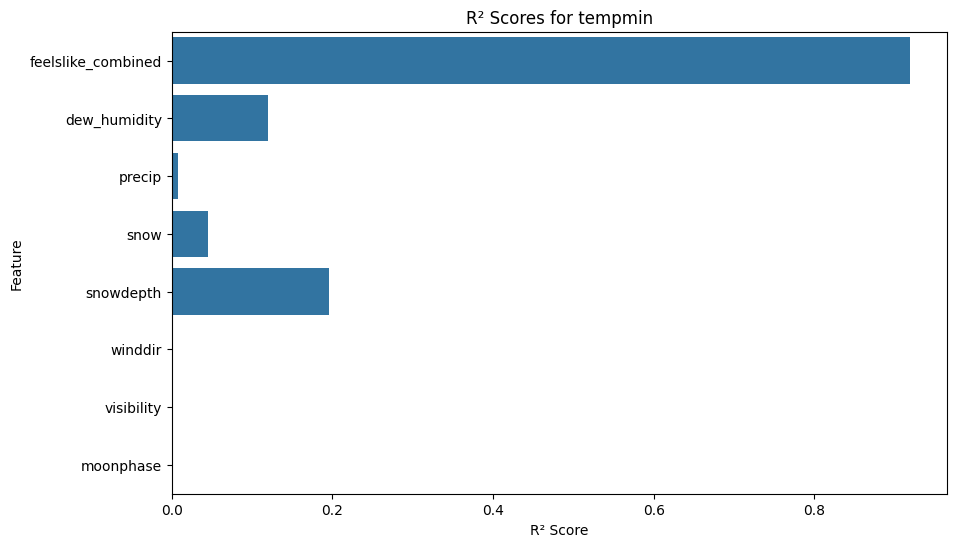

In [42]:
features = ['feelslike_combined', 'dew_humidity', 'precip', 'snow', 'snowdepth',
            'winddir', 'visibility', 'moonphase']

X = df[features]
y_max = df['tempmax']
y_min = df['tempmin']

# Initialize and fit RandomForest for feature importance
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y_min)
importances = rf_model.feature_importances_

# Create DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Calculate R² for each feature using Ridge Regression
r2_scores_max = {}
r2_scores_min = {}

# Initialize Ridge model
ridge_model = Ridge()

for feature in features:
    X_feature = X[[feature]]

    # Fit and predict for tempmax
    ridge_model.fit(X_feature, y_max)
    y_pred_max = ridge_model.predict(X_feature)
    r2_scores_max[feature] = r2_score(y_max, y_pred_max)

    # Fit and predict for tempmin
    ridge_model.fit(X_feature, y_min)
    y_pred_min = ridge_model.predict(X_feature)
    r2_scores_min[feature] = r2_score(y_min, y_pred_min)

# Create DataFrame for R² scores
r2_scores_df_max = pd.DataFrame(list(r2_scores_max.items()), columns=['Feature', 'R² (tempmax)'])
r2_scores_df_min = pd.DataFrame(list(r2_scores_min.items()), columns=['Feature', 'R² (tempmin)'])

# Plot Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Plot R² scores for tempmax
plt.figure(figsize=(10, 6))
sns.barplot(x='R² (tempmax)', y='Feature', data=r2_scores_df_max)
plt.title('R² Scores for tempmax')
plt.xlabel('R² Score')
plt.ylabel('Feature')
plt.show()

# Plot R² scores for tempmin
plt.figure(figsize=(10, 6))
sns.barplot(x='R² (tempmin)', y='Feature', data=r2_scores_df_min)
plt.title('R² Scores for tempmin')
plt.xlabel('R² Score')
plt.ylabel('Feature')
plt.show()

## Hypothesis
"A higher dew point likely predicts a higher temperature across locations, making dew point a reliable temperature predictor irrespective of geography."

## Train-Test Split
### Translate Hypothesis to Testable Statements/Validate Features

In [ ]:
from sklearn.model_selection import train_test_split

# Define target variables
y_max = df['tempmax']
y_min = df['tempmin']

# Define feature set with combined features
X = df[['feelslike_combined', 'dew_humidity', 'precip', 'snow', 'snowdepth',
        'winddir', 'visibility', 'moonphase']]

# Split training and testing data by dates
train = df.loc[df.index < '2024-03-01']
validate = df.loc[(df.index >= '2024-03-01') & (df.index < '2024-04-13')]
test = df.loc[df.index >= '2024-04-13']


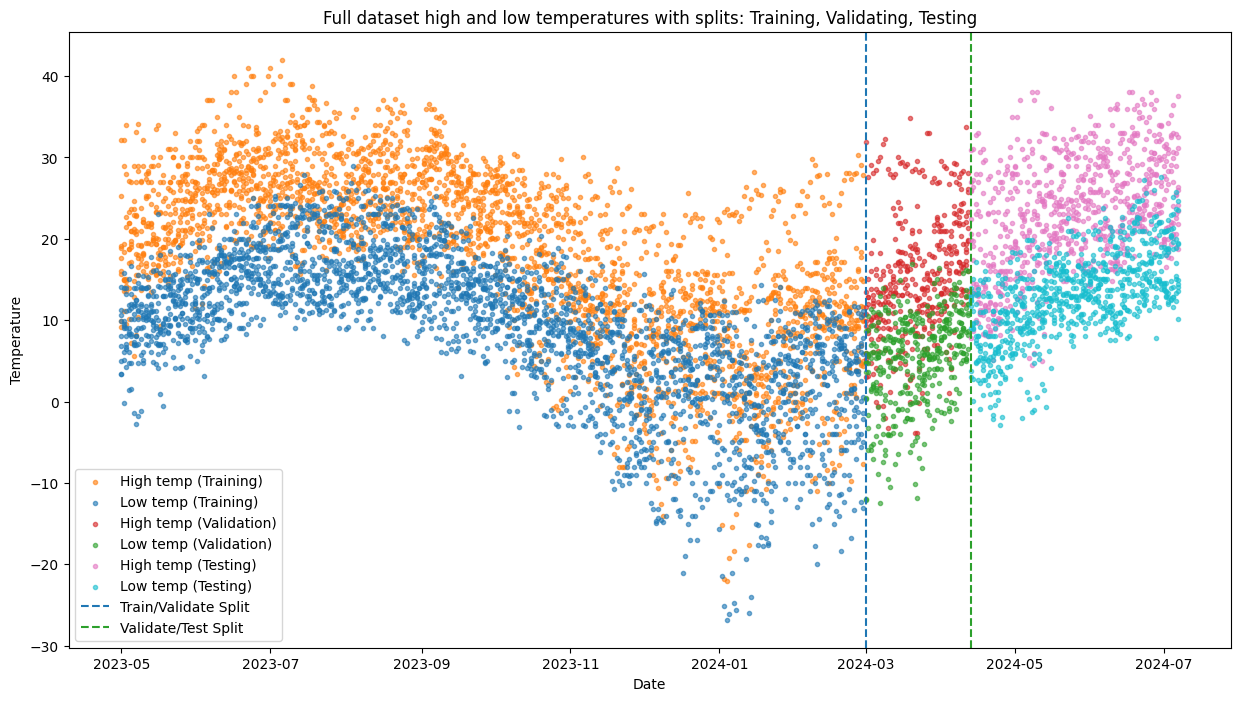

In [ ]:
# Define split dates
train_end_date = pd.to_datetime('2024-03-01')
validate_end_date = pd.to_datetime('2024-04-13')
test_start_date = pd.to_datetime('2024-04-13')

# Split the data into before and after the split date
train = df.loc[df.index < train_end_date]
validate = df.loc[(df.index >= train_end_date) & (df.index < validate_end_date)]
test = df.loc[df.index >= test_start_date]

# Create the scatter plot
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the tempmax and tempmin columns for training data
plt.scatter(train.index, train['tempmax'], color=color_pal[1], label='High temp (Training)', alpha=0.6, marker='.')
plt.scatter(train.index, train['tempmin'], color=color_pal[0], label='Low temp (Training)', alpha=0.6, marker='.')

# Plot the tempmax and tempmin columns for validation data
plt.scatter(validate.index, validate['tempmax'], color=color_pal[3], label='High temp (Validation)', alpha=0.6, marker='.')
plt.scatter(validate.index, validate['tempmin'], color=color_pal[2], label='Low temp (Validation)', alpha=0.6, marker='.')

# Plot the tempmax and tempmin columns for testing data
plt.scatter(test.index, test['tempmax'], color=color_pal[6], label='High temp (Testing)', alpha=0.6, marker='.')
plt.scatter(test.index, test['tempmin'], color=color_pal[9], label='Low temp (Testing)', alpha=0.6, marker='.')

# Add titles and labels
plt.title('Full dataset high and low temperatures with splits: Training, Validating, Testing')
plt.xlabel('Date')
plt.ylabel('Temperature')

# Add vertical lines to mark the splits
ax.axvline(train_end_date, color=color_pal[0], ls='--', label='Train/Validate Split')
ax.axvline(validate_end_date, color=color_pal[2], ls='--', label='Validate/Test Split')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Define target variables
y_train_max = train['tempmax']
y_train_min = train['tempmin']
y_validate_max = validate['tempmax']
y_validate_min = validate['tempmin']
y_test_max = test['tempmax']
y_test_min = test['tempmin']

# Define feature sets
X_train = train[['feelslike_combined', 'dew_humidity', 'precip', 'snow', 'snowdepth', 'winddir', 'visibility', 'moonphase']]
X_validate = validate[['feelslike_combined', 'dew_humidity', 'precip', 'snow', 'snowdepth', 'winddir', 'visibility', 'moonphase']]
X_test = test[['feelslike_combined', 'dew_humidity', 'precip', 'snow', 'snowdepth', 'winddir', 'visibility', 'moonphase']]

##  Model Cross Validation

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Regression": SVR()
}

# Perform cross-validation and evaluate each model
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train_max, cv=5, scoring='r2')
    print(f"{name} - Cross-Validated R²: {cv_scores.mean()}")

# Train the best model (replace RandomForestRegressor with the chosen model)
best_model = RandomForestRegressor(random_state=42)
best_model.fit(X_train, y_train_max)
y_pred_validate_max = best_model.predict(X_validate)
r2_validate_max = r2_score(y_validate_max, y_pred_validate_max)
print(f"Best Model Validation R²: {r2_validate_max}")


Linear Regression - Cross-Validated R²: 0.9638232160792398
Ridge Regression - Cross-Validated R²: 0.963823422242322
Lasso Regression - Cross-Validated R²: 0.9626569384925947
Random Forest - Cross-Validated R²: 0.9605521256159054
Gradient Boosting - Cross-Validated R²: 0.9628189229337739
Support Vector Regression - Cross-Validated R²: 0.753077718810853
Best Model Validation R²: 0.9381268787596166


## Model Training and Evaluation